In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler, abc_rejection_sampler2
import seaborn as sns
from scipy.stats import norm, lognorm

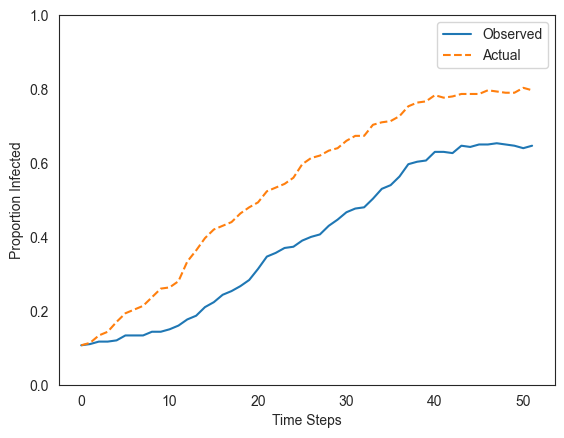

In [2]:
sns.set_style("white")

beta_true = [0.05, .1, .2, .3, .4, .5, 5]
alpha = 0.1
gamma = 0.02
eta = 0.1 # interpretation: after one week, a colonized patient will show symptoms with probability .5
heterogeneous = True
N = 300 # consider increasing
T = 52
K = 30
data_seed = 31
prior_mu = [-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]
prior_sigma = [1, 1, 1, 1, 1, 1, 1]

si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed, eta=eta)
y_o = si_model.get_observed_data()


si_model_alt = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed, eta=.999)

x_o = si_model_alt.get_observed_data()


sns.lineplot(y_o[0, :], label="Observed")
sns.lineplot(x_o[0, :], label="Actual", linestyle="--")

plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/partial_obs.png")
plt.show()

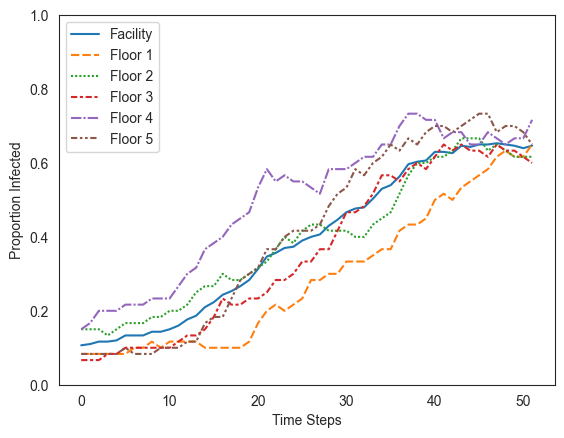

In [4]:
data = y_o[:6,:]

data = pd.DataFrame(data = data.T, columns=["Facility"] + [f"Floor {i}" for i in range(1,6)])

sns.lineplot(data)
plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/partial_obs_floor_viz.png")
plt.show()

# Partial Observation

In [5]:
df_partial= pd.read_csv("partial_obs2.csv")

In [29]:
mu = eval(df_partial["mu"].values[0])[0]
# mu

sigma = eval(df_partial["sigma"].values[0])
sds = [sigma[i][i]**0.5 for i in range(7)]
# sds

rates = [np.exp(mu[i] + sds[i]**2/2) for i in range(7)]

AttributeError: module 'numpy' has no attribute 'arr'

In [30]:
np.round(np.array(rates), 3)

array([0.047, 0.116, 0.228, 0.245, 0.555, 0.41 , 4.928])

In [28]:
# 90% credible intervals
for i in range(7):
    dist = norm(mu[i], sds[i])
    a, b = dist.ppf(0.05), dist.ppf(0.95)
    print(np.round(np.exp(a), 3), np.round(np.exp(b), 3))

0.025 0.08
0.032 0.275
0.066 0.528
0.073 0.559
0.233 1.069
0.151 0.847
0.573 15.506


In [17]:
def lognormal_sd(m, s):
    a = np.exp(s**2) - 1
    b = np.exp(2*m + s**2)
    return (a*b)**0.5

In [18]:
for i in range(7):
    print(lognormal_sd(mu[i], sds[i]))

0.017689560024519838
0.08509996262970793
0.15995021362522374
0.16716586227355815
0.2718247733690833
0.23094244323171864
6.4838711092658725


# ABC

In [19]:
si_model = SIModel(alpha, gamma, beta_true, heterogeneous,
                  prior_mu, prior_sigma, N=N, T=T, summarize=False)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(31)

epsilon = 1.9

S = 100
print(f"epsilon: {epsilon}")
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=30000,
    print_every=1000, summarize=False
    )

epsilon: 1.9
Attempts: 1,000
Attempts: 2,000
Attempts: 3,000
Attempts: 4,000
Attempts: 5,000
Time lapsed: 97.09 seconds
With tolerance 1.9, acceptance rate: 0.017931
Total number of attempts: 5,577


In [34]:
np.round(np.exp(posterior_sample).mean(0),3)

array([0.062, 0.14 , 0.221, 0.197, 0.328, 0.307, 3.927], dtype=float32)

In [31]:
a = np.round(np.quantile(np.exp(posterior_sample), 0.05, 0), 3)

In [32]:
b = np.round(np.quantile(np.exp(posterior_sample), 0.95, 0), 3)

In [33]:
list(zip(a, b))

[(0.034, 0.094),
 (0.025, 0.293),
 (0.044, 0.522),
 (0.053, 0.399),
 (0.059, 0.689),
 (0.082, 0.578),
 (0.704, 11.162)]